# IMPORT PACKAGES

In [ ]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from keras import layers, models
import pathlib
import natsort
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [ ]:
epochs = 10000
batch = 16
eta = 0.001
weight_decay = 6e-8
imageShape = (224, 224, 1)
maskShape = (224, 224, 1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy the File from Google Drive:

file_path = '/content/childrens-dental-panoramic-radiographs-dataset.zip'

# Check if the file exists
if not os.path.exists(file_path):
    # File does not exist, download it from Google Drive
    !cp '/content/drive/My Drive/childrens-dental-panoramic-radiographs-dataset.zip' '/content/'
else:
    print("File already exists.")


In [ ]:
if not os.path.exists('/content/Dental_dataset'):
    # Unzip the dataset
    !unzip -q '/content/drive/My Drive/childrens-dental-panoramic-radiographs-dataset.zip' -d /content/
else:
    print("Dataset already extracted.")


# READ DATASET (IMAGES, MASKS)

In [ ]:
class readDataset:
    def __init__(self, imagesPathes, masksPathes):
        self.imagesPathes = imagesPathes
        self.masksPathes = masksPathes
    def readPathes(self,):
      self.images = natsort.natsorted(list(pathlib.Path(self.imagesPathes).glob('*.*')))
      self.masks = natsort.natsorted(list(pathlib.Path(self.masksPathes).glob('*.*')))
    def readImages(self, data, typeData):
        images = []
        for img in data:
            img = cv2.imread(str(img), 0)
            img = img/255
            img = cv2.resize(img, (224, 224))
            if typeData == 'm':
                img = np.where(img > 0, 1, 0)
            images.append(img)
        return np.array(images)
    def dataAugmentation(self, images, masks):
        imagesupdate = []
        masksupdate = []
        for image, mask in zip(images, masks):
          for aug in range(2):
            imageup = image
            maskup = mask
            if aug == 0:
              imageup = image
              maskup = mask
            else:
              imageup = tf.image.flip_left_right(imageup)
              maskup = tf.image.flip_left_right(maskup)
            imagesupdate.append(imageup), masksupdate.append(maskup)
        return np.array(imagesupdate), np.array(masksupdate)

In [ ]:
datasetObject = readDataset('/content/Dental_dataset/Adult tooth segmentation dataset/Panoramic radiography database/images',
                            '/content/Dental_dataset/Adult tooth segmentation dataset/Panoramic radiography database/mask')
datasetObject.readPathes()

In [ ]:
len(datasetObject.images), len(datasetObject.masks)

(598, 598)

In [ ]:
images = datasetObject.readImages(datasetObject.images, 'i')
masks = datasetObject.readImages(datasetObject.masks, 'm')
images.shape, masks.shape

((598, 224, 224), (598, 224, 224))

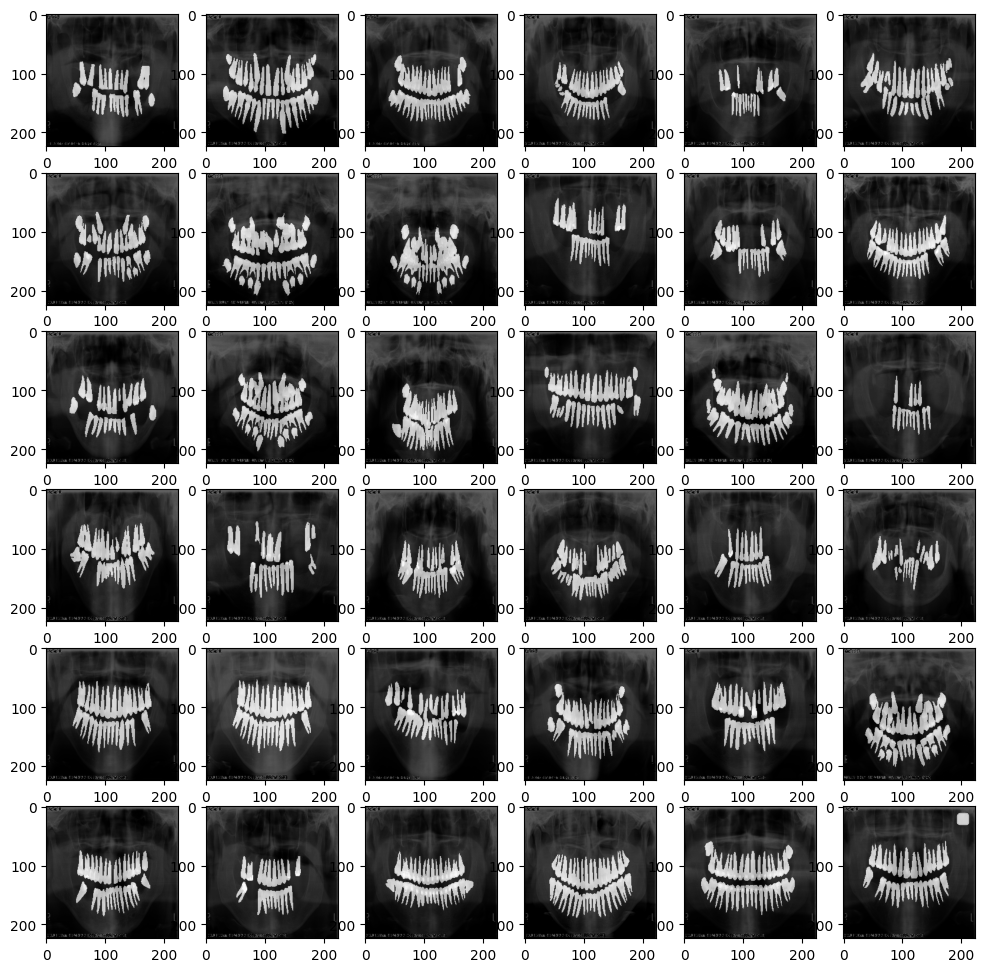

In [ ]:
plt.figure(figsize = (12, 12))
for i in range(36):
    plt.subplot(6, 6, (i + 1))
    plt.imshow(images[i], cmap = 'gray')
    plt.imshow(masks[i], alpha = 0.6, cmap = 'gray')
plt.legend()

In [ ]:
np.unique(masks), np.min(masks), np.max(masks), np.min(images), np.max(masks)

(array([0, 1]), 0, 1, 0.0, 1)

In [ ]:
x = layers.Input(shape = (224, 224, 1))
y = layers.Input(shape = (224, 224, 1))
z = layers.multiply([x, y])
m = models.Model(inputs = [x, y], outputs = z)
m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 multiply (Multiply)         (None, 224, 224, 1)          0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte

In [ ]:
imagesByMasks = m([images[:64], masks[:64]])
imagesByMasks.shape

TensorShape([64, 224, 224, 1])

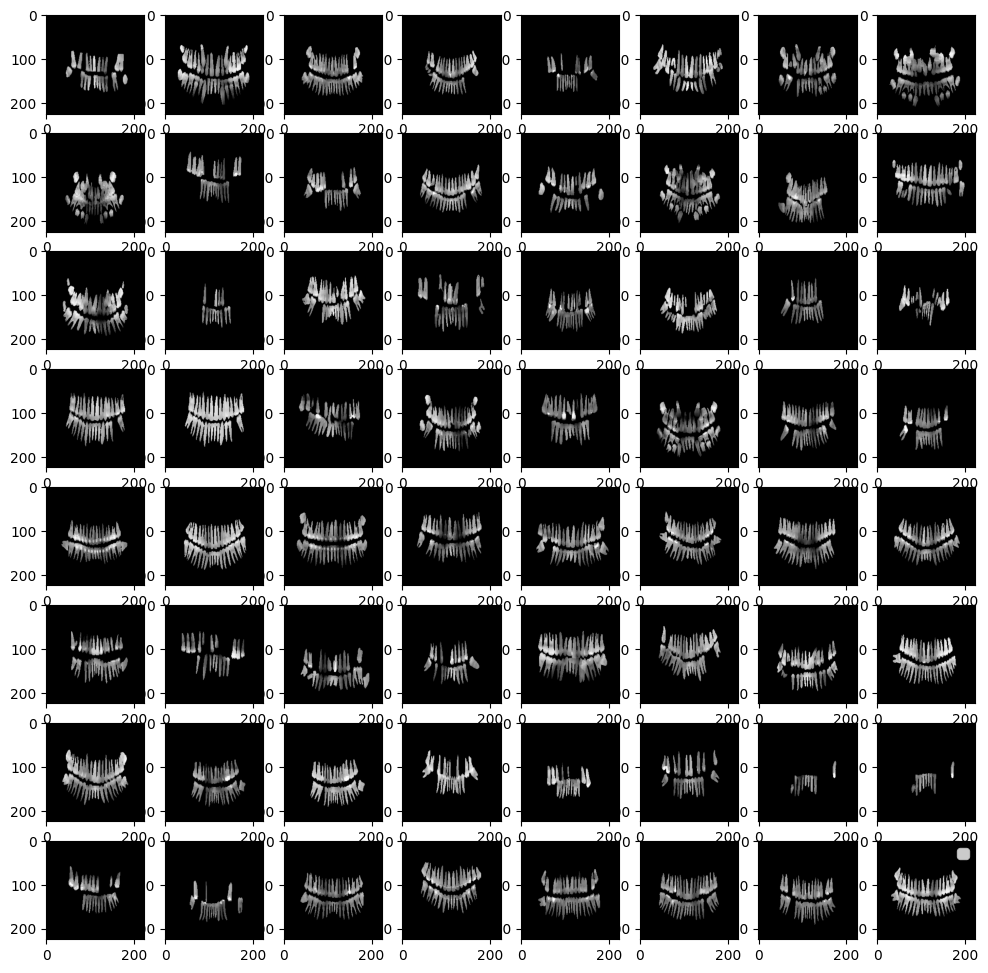

In [ ]:
plt.figure(figsize = (12, 12))
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(imagesByMasks[i], cmap = 'gray')
plt.legend()

In [ ]:
i = 80
validImages = images[:i]
validMasks = masks[:i]
trainImages = images[i:]
trainMasks = masks[i:]
validImages.shape, validMasks.shape, trainImages.shape, trainMasks.shape

((80, 224, 224), (80, 224, 224), (518, 224, 224), (518, 224, 224))

# Proposing a generative neural network architecture

In [ ]:
def convolution(inputs, filter, padding, strides, kernel, activation, conv_type):
  x = inputs
  x = layers.Conv2D(filter, kernel_size = kernel, padding = padding,
                    strides = strides)(x)
  x = layers.GroupNormalization(groups = filter)(x)
  if conv_type == 'decoder':
      x = layers.Activation(activation)(x)
      x = layers.Conv2D(filter*2, kernel_size = kernel, padding = padding, strides = strides)(x)
      x = layers.GroupNormalization(groups = filter*2)(x)
      x = layers.Activation(activation)(x)
      x = layers.Conv2D(filter, kernel_size = kernel, padding = padding, strides = strides)(x)
      x = layers.GroupNormalization(groups = filter)(x)
  x = layers.average([x, layers.Conv2D(filter, kernel_size = 1, padding = 'same',
                                      strides = 1)(inputs)])
  x = layers.Activation(activation)(x)
  return x

In [ ]:
def encoder(input, filter, padding, strides, kernel, activation):
  x = input
  x = convolution(x, filter, padding, strides, kernel, activation, 'encoder')
  downsample = layers.AveragePooling2D()(x)
  return downsample, x

In [ ]:
def decoder(input, filter, skip, padding, strides, kernel, activation):
  x = input
  x = layers.Conv2DTranspose(filter, kernel_size = kernel, padding = padding,
                             strides = 2, activation = activation)(x)
  x = layers.average([x, skip])
  x = convolution(x, filter, padding, strides, kernel, activation, 'decoder')
  return x

In [ ]:
def generator(input, filter, padding, strides, kernel, weights):
  x = input
  con1, skip1 = encoder(x, filter, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  con2, skip2 = encoder(con1, filter*2, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  con3, skip3 = encoder(con2, filter*4, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  con4, skip4 = encoder(con3, filter*8, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  con5, skip5 = encoder(con4, filter*16, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  deco = decoder(con5, filter*16, skip5, padding = padding, strides = strides,
                  kernel = kernel, activation = 'relu')
  deco1 = decoder(deco, filter*8, skip4, padding = padding, strides = strides,
                  kernel = kernel, activation = 'relu')
  deco2 = decoder(deco1, filter*4, skip3, padding = padding, strides = strides,
                  kernel = kernel, activation = 'relu')
  deco3 = decoder(deco2, filter*2, skip2, padding = padding, strides = strides,
                  kernel = kernel, activation = 'relu')
  deco4 = decoder(deco3, filter, skip1, padding = padding, strides = strides,
                  kernel = kernel, activation = 'relu')
  output = layers.Conv2DTranspose(1, kernel_size = kernel, strides = strides,
                                  padding = padding, activation = 'sigmoid')(deco4)
  generator = models.Model(inputs = input, outputs = output, name = 'generator')
  #if weights != None:
  generator.load_weights('/content/mask_generator.h5')
  generator.summary()
  return generator

In [ ]:
# Copy generator weights from Google Drive to Colab
!cp '/content/drive/My Drive/mask_generator.h5' '/content/'

!cp '/content/drive/My Drive/mask_discriminator.h5' '/content/'

In [ ]:
G = generator(input = layers.Input(shape = (224, 224, 1)), filter = 32,
              padding = 'same', kernel = 3, strides = 1, weights = None)

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 32)         320       ['input_3[0][0]']             
                                                                                                  
 group_normalization (Group  (None, 224, 224, 32)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 32)         64        ['input_3[0][0]']     

In [ ]:
def discriminator(ImageInput, maskInput, filter, padding, strides, kernel, weights,
                  lossFn, learning_rate, weight_decay):
  x = layers.multiply([ImageInput, maskInput])
  con1, skip1 = encoder(x, filter, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  con2, skip2 = encoder(con1, filter*2, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  con3, skip3 = encoder(con2, filter*4, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  con4, skip4 = encoder(con3, filter*8, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  con5, skip5 = encoder(con4, filter*16, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  x = layers.GlobalAveragePooling2D()(con5)
  x = layers.Dropout(0.1)(x)
  x = layers.Dense(1)(x)
  discriminator = models.Model(inputs = [maskInput, ImageInput], outputs = x,
                              name = 'discriminator')
  #if weights != None:
  discriminator.load_weights('/content/mask_discriminator.h5')
  discriminator.compile(loss = lossFn, optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate,
                                                                              weight_decay = weight_decay))
  discriminator.summary()
  return discriminator

In [ ]:
D = discriminator(ImageInput = layers.Input(shape = imageShape), maskInput = layers.Input(shape = maskShape),
                  filter = 32, padding = 'same', strides = 1, kernel = 3, weights = None,
                  lossFn = 'mse', learning_rate = eta, weight_decay = weight_decay)

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 multiply_1 (Multiply)       (None, 224, 224, 1)          0         ['input_4[0][0]',             
                                                                     'input_5[0][0]']             
                                                                                                  
 conv2d_30 (Conv2D)          (None, 224, 224, 32)         320       ['multiply_1[0][0]

In [ ]:
def GAN(discriminator, generator, imageInput, maskInput, learning_rate, weight_decay,
                   lossFn):
  discriminator.trainable = False
  gan = models.Model(
      inputs = [imageInput],
      outputs = discriminator([generator(imageInput), imageInput],),
      name = 'gan'
  )
  gan.compile(loss = lossFn, optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate*0.5,
                                                                              weight_decay = weight_decay*0.5))
  gan.summary()
  return gan

In [ ]:
gan = GAN(discriminator = D, generator = G, imageInput = layers.Input(shape = imageShape),
          maskInput = layers.Input(shape = maskShape), learning_rate = eta, weight_decay = weight_decay,
                   lossFn = 'mse')

Model: "gan"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 generator (Functional)      (None, 224, 224, 1)          2174774   ['input_6[0][0]']             
                                                          5                                       
                                                                                                  
 discriminator (Functional)  (None, 1)                    1745601   ['generator[0][0]',           
                                                                     'input_6[0][0]']             
                                                                                                

In [ ]:
def samples(generator, images, realMasks):
  masks = tf.squeeze(generator.predict(images))
  all = np.vstack([realMasks, masks])
  plt.figure(figsize = (12, 4))
  for i in range(16):
    plt.subplot(2, 8, (i + 1))
    plt.imshow(all[i], cmap = 'gray')
  plt.show()

In [ ]:
for epoch in range(epochs):
    indexs = np.random.randint(0, len(trainImages), size = (batch, ))
    realImages = trainImages[indexs]
    realMasks = trainMasks[indexs]
    realTag = tf.ones(shape = (batch, ))
    fakeMasks = tf.squeeze(G.predict([realImages], verbose = 0))
    fakeTag = tf.zeros(shape = (batch, ))
    allMasks = np.vstack([realMasks, fakeMasks])
    allTags = np.hstack([realTag, fakeTag])
    allImages = np.vstack([realImages, realImages])
    dlossTag = D.train_on_batch([allMasks, allImages], [allTags])
    glossTag = gan.train_on_batch([realImages], [realTag,])
    if epoch % 100 == 0:
          print('Epoch/Epochs: {}/{}'.format(epoch, epochs))
          print('discriminator loss: [tag: {},], generator loss: [tag: {},]'.format(dlossTag, glossTag))
          validIndexs = np.random.randint(0, len(validImages), size = (8, ))
          samples(G, validImages[validIndexs], validMasks[validIndexs])

In [ ]:
G.save_weights('/content/mask_generator.h5')
D.save_weights('/content/mask_discriminator.h5')

In [ ]:
G.save_weights('/content/drive/My Drive/mask_generator.h5')
D.save_weights('/content/drive/My Drive/mask_discriminator.h5')

In [ ]:
G = generator(input = layers.Input(shape = (224, 224, 1)), filter = 32,
              padding = 'same', kernel = 3, strides = 1, weights = True)
for layer in G.layers[:20]:
  layer.trainable = False
G.compile(loss = tf.keras.losses.BinaryFocalCrossentropy(),
                  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001),
                  metrics = ['accuracy', tf.keras.metrics.Precision(name = 'precision'),
                             tf.keras.metrics.Recall(name = 'recall')])
G.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d_130 (Conv2D)         (None, 224, 224, 32)         320       ['input_11[0][0]']            
                                                                                                  
 group_normalization_85 (Gr  (None, 224, 224, 32)         64        ['conv2d_130[0][0]']          
 oupNormalization)                                                                                
                                                                                                  
 conv2d_131 (Conv2D)         (None, 224, 224, 32)         64        ['input_11[0][0]']    

# Evaluation of training performance using generative neural networks on both training and test data

In [ ]:
G.evaluate(validImages, validMasks)

3/3 [==============================] - 6s 357ms/step - loss: 0.2944 - accuracy: 0.9775 - precision: 0.9225 - recall: 0.8770


[0.2943868041038513,
 0.9775423407554626,
 0.9224913120269775,
 0.8769969344139099]

In [ ]:
G.evaluate(trainImages, trainMasks)

17/17 [==============================] - 8s 444ms/step - loss: 0.2709 - accuracy: 0.9790 - precision: 0.9285 - recall: 0.8859


[0.27088475227355957,
 0.9790380001068115,
 0.9284613132476807,
 0.8859279155731201]

# Re-training of the generator according to the pixel2pixel methodology

In [ ]:
history = G.fit(trainImages, trainMasks, epochs = 160, batch_size = 8,
                        validation_data = (validImages, validMasks), callbacks = [
                            tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss',
                                                             mode = 'min',
                                                             restore_best_weights = True)
                        ])

# The results obtained

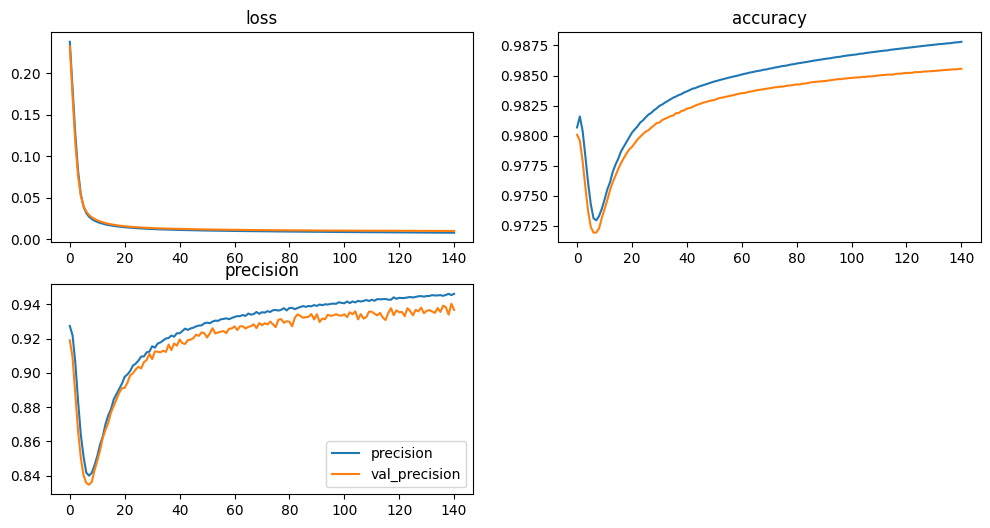

In [ ]:
metrics = ['loss','accuracy', 'precision',]
plt.figure(figsize = (12, 6))
for i in range(3):
    plt.subplot(2, 2, (i + 1))
    plt.plot(history.history['{}'.format(metrics[i])], label = '{}'.format(metrics[i]))
    plt.plot(history.history['val_{}'.format(metrics[i])], label = 'val_{}'.format(metrics[i]))
    plt.title('{}'.format(metrics[i]))

plt.legend()

In [ ]:
G.evaluate(validImages, validMasks)

3/3 [==============================] - 3s 351ms/step - loss: 0.0100 - accuracy: 0.9855 - precision: 0.9384 - recall: 0.9342


[0.00996988732367754, 0.9854875802993774, 0.938430666923523, 0.934188187122345]

In [ ]:
G.evaluate(trainImages, trainMasks)

17/17 [==============================] - 8s 439ms/step - loss: 0.0079 - accuracy: 0.9877 - precision: 0.9468 - recall: 0.9463


[0.007874217815697193,
 0.9877142310142517,
 0.9468390345573425,
 0.9462642669677734]

In [ ]:
G.save('/content/final_tooth_mask_generation.h5')
G.save('/content/drive/My Drive/final_tooth_mask_generation.h5')

In [ ]:
G = tf.keras.models.load_model('/content/drive/My Drive/final_tooth_mask_generation.h5')

In [ ]:
masks_pred = G.predict(validImages)
masks_pred = (masks_pred >= 0.5).astype('int')

3/3 [==============================] - 4s 480ms/step


In [ ]:
masks_pred.shape

(80, 224, 224, 1)

In [ ]:
def draw(images, masks, y_pred):
  plt.figure(figsize = (12, 50))
  index = -1
  n = np.random.randint(y_pred.shape[0])
  for i in range(120):
    plt.subplot(20, 6, (i + 1))
    if index == -1:
      plt.imshow(images[n], cmap = 'gray')
      plt.title('Image')
      index = 0
    elif index == 0:
      plt.imshow(images[n], cmap = 'gray')
      plt.imshow(masks[n], alpha = 0.6, cmap = 'gray')
      plt.title('Original Mask')
      index = 1
    elif index == 1:
      plt.imshow(images[n], cmap = 'gray')
      plt.imshow(np.reshape(y_pred[n], (224, 224)), alpha = 0.6, cmap = 'gray')
      plt.title('Predict Mask')
      index = -1
      n = np.random.randint(y_pred.shape[0])
  plt.legend()

In [ ]:
draw(validImages, validMasks, masks_pred)

In [ ]:
masks_pred = G.predict(trainImages)
masks_pred = (masks_pred >= 0.5).astype('int')

17/17 [==============================] - 7s 454ms/step


In [ ]:
masks_pred.shape

(518, 224, 224, 1)

In [ ]:
draw(trainImages, trainMasks, masks_pred)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
draw(trainImages, trainMasks, masks_pred)